<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-processamento de características

Na aula de hoje, vimos os procedimentos de remoção de outliers e de normalização do espaço de características. Nesta atividade, vamos garantir que compreendemos o que está envolvido nestes processos. Para isso, vamos utilizar as funções *t3_remoutliers*, *t3_normaliza* e *t3_preselec* que estão disponíveis no github do curso.

In [1]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
from scipy.stats import shapiro
import seaborn as sns
import operator

In [2]:
# leitura e tratamento dos dados
data_1 = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-3/Dados1.mat")['sinal']
data_2 = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-3/Dados2.mat")

**A)** Leia as funções mencionadas e garanta que você compreende o que elas
fazem *(observe os slides da aula, pesquise a respeito dos métodos
empregados ou tire dúvidas com o professor ou a tutora, mas não empregue
estas funções sem compreendê-las)*.

In [3]:
def t3_remoutliers(padroes,p,method='desvio'):
   #Encontra outlires baseando-se em dois métodos possiveis:
    #  method = 'desvio': mediana +-p x desvio
    #  method = 'quartis': quartis  +-p x intervalo entre quartis
    # padroes = numpy array de uma característica (N x 1)
    # p = numero de desvios ou de intervalos entre quartis a ser empregado
    # retorna lista com as posicoes dos outliers no array
    if method =='desvio':
        md=np.median(padroes)
        std=np.std(padroes,ddof=1)
        th1=md+p*std
        th2=md-p*std
    elif method=='quartis':
        q3, q1 = np.percentile(padroes, [75 ,25])
        iqr=q3-q1
        th1=q3+p*iqr
        th2=q1-p*iqr
    outliers=(padroes>th1) | (padroes<th2)
    outs=[i for i, val in enumerate(outliers) if val]
    return outs

In [4]:
def t3_normaliza(dados,metodo='linear',r=1):
    #Realiza a normalizacao de um conjunto de padroes
    # dados = numpy array com padroes de uma caracteristica N x 1
    # metodo ='linear' : normalizacao linear (padrao)
    #        = 'mmx': limitada entre -1 e 1
    #        = 'sfm': rescala nao linear no intervalo 0 a 1
    # r = parametro do metodo sfm (padrao =1)
    #A função retorna os dados normalizados
    if metodo=='linear':
        M=np.mean(dados)
        S=np.std(dados,ddof=1)
        dadosnorm=(dados-M)/S
    elif metodo=='mmx':
        dadosnorm=2*dados/(np.max(dados)-np.min(dados))
        dadosnorm=dadosnorm - (np.min(dadosnorm)+1)
    elif metodo=='sfm':
        x=dados-np.mean(dados)
        x=-x/(r*np.std(dados))
        dadosnorm=1/(1+np.exp(x))
    return dadosnorm

In [5]:
def t3_preselec(dados1,dados2,alfa,verbose=True):
    #A função retorna os indices das características que apresentaram
    #significatividade ("rel") e os p-values das características na
    #distinção entre classes ("p")
    #Inputs:
    # - dados1 = array características x padrões da primeira classe
    # - dados2 = array características x padrões da segunda classe
    # - alfa = taxa de erro tipo I do teste (por exemplo, alfa=0.05)
    Ncarac,Npad=dados1.shape
    Ncarac2,Npad2=dados2.shape
    if Ncarac2!= Ncarac:
        print('Erro: matrizes devem ter o mesmo numero de caracteristicas!')
        return
    p=np.zeros(Ncarac)
    for i in range(Ncarac):
        s1=st.shapiro(dados1[i,:])
        s2=st.shapiro(dados2[i,:])
        if (s1[1]<0.05) | (s2[1]<0.05):
            res=st.ranksums(dados1[i,:],dados2[i,:])
            p[i]=res.pvalue
            if verbose:
                print('Aviso: normalidade rejeitada para a caracteristica nº '+ str(i+1))
        else:
            res=st.ttest_ind(dados1[i,:],dados2[i,:])
            p[i]=res.pvalue
    relevantes=(p<alfa)
    rel=[i for i,val in enumerate(relevantes) if val]
    return rel,p

**B)** Teste a remoção de outliers usando diferentes parâmetros nos dados do
arquivo “Dados1.mat” disponível no material do Classroom desta aula

Quando removemos outliers, devemos remover de cada classe individualmente.

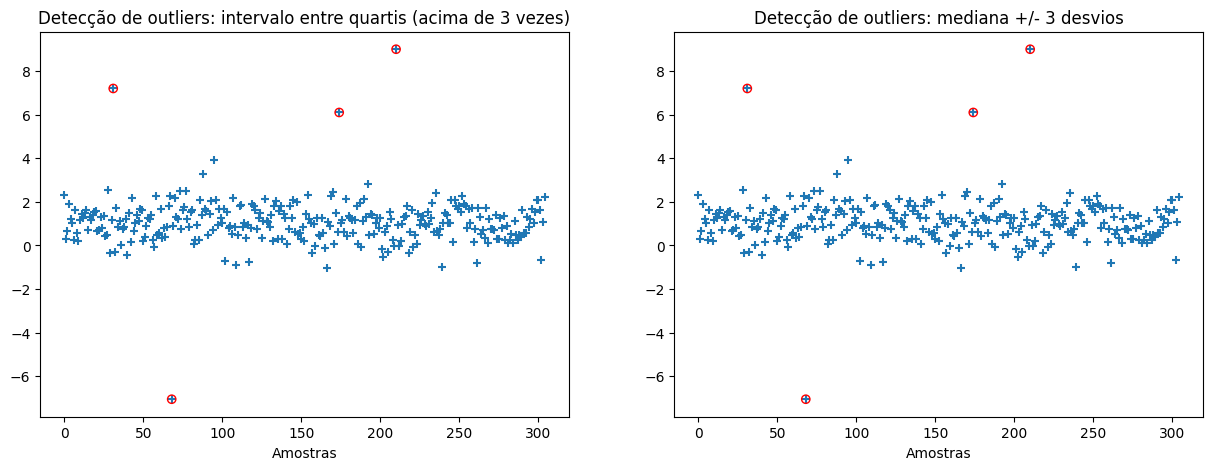

In [6]:
# aplicando a função de remoção de outliers no primeiro conjunto
outliers = [t3_remoutliers(data_1,3,method='quartis'),t3_remoutliers(data_1,3,method='desvio')]

# plot dos dados e outliers
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

# intervalo entre quartis
plt.scatter(np.arange(len(data_1)), data_1, marker="+")
plt.scatter(outliers[0], data_1[outliers[0]], facecolors='none', edgecolors='red')
plt.title("Detecção de outliers: intervalo entre quartis (acima de 3 vezes)")
plt.xlabel("Amostras")

plt.subplot(1,2,2)
# critério da mediana
plt.scatter(np.arange(len(data_1)), data_1, marker="+")
plt.scatter(outliers[1], data_1[outliers[1]], facecolors='none', edgecolors='red')
plt.title("Detecção de outliers: mediana +/- 3 desvios")
plt.xlabel("Amostras")

plt.show()

**C)** Teste a normalização nos dados do arquivo “Dados2.mat” disponível no material do Classroom desta aula. Este arquivo possui medidas histopatológicas de duas classes distintas de astrocitomas *(alto grau e baixo grau)*. As características no arquivo correspondem às médias *(variável “med”)* e às obliquidades *(variável “ske”)* dos tons de cinza das imagens. Cada uma dessas variáveis contém 5 padrões para cada classe *(as matrizes possuem a dimensão N x C, onde N=5 é o número de padrões e C=2 é o número de classes)*. Teste diferentes métodos de normalização em tais dados e plote as diferentes classes no espaço das características.

Quando normalizamos, devemos fazer isso para as classes juntas em um so vetor, uma vez que se fizermos isso para cada uma, podemos encontrar sobreposição nos espaço de características.

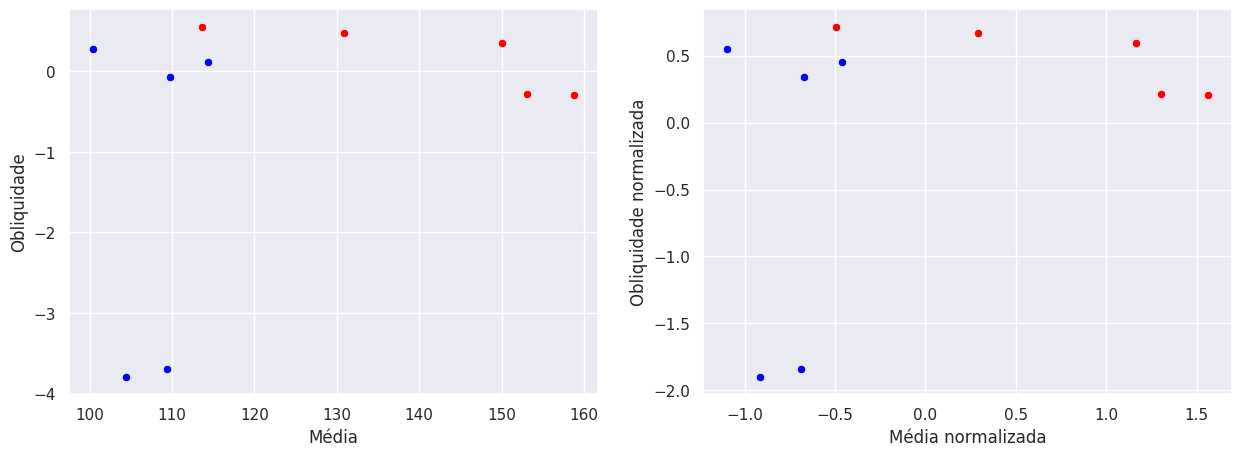

In [7]:
# dados originais
plt.figure(figsize=(15,5))
sns.set_theme()

plt.subplot(1,2,1)
sns.scatterplot(x=data_2['med'][:,0], y=data_2['ske'][:,0],markers='O', color='blue')
sns.scatterplot(x=data_2['med'][:,1], y=data_2['ske'][:,1],markers='O', color='red')
plt.xlabel("Média")
plt.ylabel("Obliquidade")

# dados normalizados - todas as classes devem estar no mesmo vetor
mean_list = np.concatenate((data_2['med'][:,0], data_2['med'][:,1]))
ske_list = np.concatenate((data_2['ske'][:,0], data_2['ske'][:,1]))

mean_norm = t3_normaliza(mean_list, metodo='linear', r=1)
ske_norm = t3_normaliza(ske_list, metodo='linear', r=1)

# plot dos dados normalizados
plt.subplot(1,2,2)
sns.scatterplot(x=mean_norm[0:5], y=ske_norm[0:5], markers='O', color='blue')
sns.scatterplot(x=mean_norm[5:10], y=ske_norm[5:10], markers='O', color='red')
plt.xlabel("Média normalizada")
plt.ylabel("Obliquidade normalizada")

plt.show()

**D)** Teste o processo de pré-seleção baseado em teste estatístico, para determinar características irrelevantes na distinção das duas classes de astrocitomas descritas no item anterior. Observe os dados e verifique se o resultado é aquele esperado 1. *(Resposta: a característica “Obliquidade” é
estatisticamente irrelevante na distinção das classes; o mesmo não pode ser
afirmado para a característica “Media”)*.

In [8]:
# separando as duas classes
class_1 = np.asarray([mean_norm[0:5], ske_norm[0:5]])
class_2 = np.asarray([mean_norm[5:10], ske_norm[5:10]])

# realizando o teste estatístico das duas classes
print(f'Classe 1: {shapiro(class_1)}')
print(f'Classe 2: {shapiro(class_2)}')

Classe 1: ShapiroResult(statistic=0.9209907054901123, pvalue=0.36529168486595154)
Classe 2: ShapiroResult(statistic=0.9668848514556885, pvalue=0.8605561256408691)


Através da análise do valor estatístico e do p-valor, então não devemos rejeitar a hipótese de normalidade.

In [9]:
# fazendo a pre-selecao de caracteristicas
pre_select = t3_preselec(class_1, class_2, 0.05, verbose=True)

Aviso: normalidade rejeitada para a caracteristica nº 2


A normalidade da característica número 2 (obliquidade) foi rejeitada. Isso significa que não importa para qual classe seja. A obliquidade deve ser considerada em outro teste estatístico.

# Curva ROC

Neste exercício, vamos calcular a área embaixo da curva ROC para as características obtidas nas duas classes de astrocitomas descritas no exercício acima. Você pode escrever o seu próprio algoritmo para encontrar a ROC ou utilizar funções existentes, como o método “t3_fazroc” que está disponível no github do curso, mas em qualquer um dos casos, garanta que você compreendeu o que está sendo calculado.

In [10]:
def t3_fazroc(dados1,dados2,nomecarac='',plotar=True):
    #função que calcula a ROC para ser aplicada em dois conjuntos de padroes (uma caracteristica)
    #Inputs:
    # - dados1 = numpy array com padroes de uma caracteristica para a primeira classe N1 x 1
    # - dados2 = numpy array com padroes de uma caracteristica para a segunda classe N2 x 1
    # - nomecarac = nome da característica para o gráfico
    # - plotar = faz o gráfico da ROC (True or False)
    #Outputs:
    # - auc = área embaixo da curva ROC
    # - fpr = taxas de falsos positivos em função do limiar
    # - tpr = taxas de verdadeiros positivos em função do limiar
    # - acuracia = acuracias totais em função do limiar
    # - thresholds = limiares da roc
    # - classes = classes dos dois inputs (1 ou -1)
    Np1=dados1.shape[0]
    Np2=dados2.shape[0]
    classes=np.zeros(Np1+Np2)
    classes[0:Np1]=-1
    classes[Np1:Np1+Np2]=1
    dados=np.concatenate((dados1,dados2),axis=0)
    s=dados.argsort()
    thresholds=dados[s]
    classessort=classes[s]
    tpr=np.zeros(len(classes)+1)
    fpr=np.zeros(len(classes)+1)
    acuracia=np.zeros(len(classes)+1)
    erro=np.zeros(len(classes)+1)
    for i in range(len(classessort)):
        pos=classessort[i:]
        tpr[i]=sum(pos==1)/sum(classes==1)
        fpr[i]=sum(pos==-1)/sum(classes==-1)
        acuracia[i]=(sum(pos==1) + (sum(classes==-1)-sum(pos==-1)))/(sum(classes==1)+sum(classes==-1))
        erro[i]=(sum(pos==-1) + (sum(classes==1)-sum(pos==1)))/(sum(classes==1)+sum(classes==-1))
    auc=-np.trapz(tpr,x=fpr)
    classes=[-1,1] #classes dos dois input
    if auc<0.5:
        auc=1-auc
        fpr2=fpr
        fpr=tpr
        tpr=fpr2
        acuracia2=acuracia
        acuracia=erro
        erro=acuracia2
        classes=[1,-1] #classes dos dois inputs
    if plotar:
            plt.figure()
            plt.plot(fpr,tpr)
            plt.title(nomecarac+' AUC = '+'{:.2}'.format(auc))
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.show(block=False)
    return auc, fpr, tpr, classes, thresholds, acuracia

In [11]:
# normalizando as características de cada classe
mean_norm_1 = np.asarray(data_2['med'][:,0])
mean_norm_2 = np.asarray(data_2['med'][:,1])
ske_norm_1 = np.asarray(data_2['ske'][:,0])
ske_norm_2 = np.asarray(data_2['ske'][:,1])

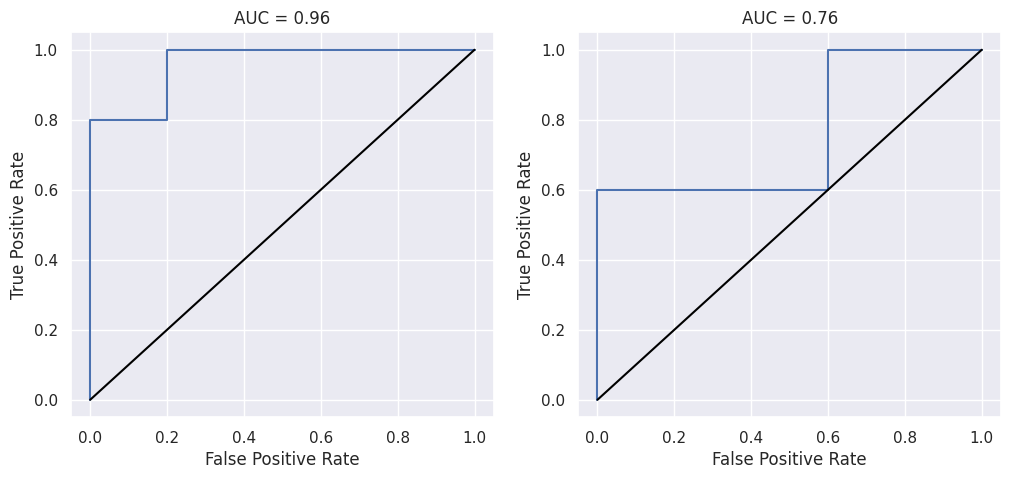

In [12]:
# processo para plotar a curva ROC
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
auc_1, fpr_1, tpr_1, classes_1, thresholds_1, acuracia_1 = t3_fazroc(mean_norm_1, mean_norm_2, nomecarac='med', plotar=False)
plt.plot(fpr_1, tpr_1)
plt.plot(fpr_1, fpr_1, color='black')
plt.title('AUC = '+'{:.2}'.format(auc_1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot(1,2,2)
auc_2, fpr_2, tpr_2, classes_2, thresholds_2, acuracia_2 = t3_fazroc(ske_norm_1, ske_norm_2, nomecarac='', plotar=False)
plt.plot(fpr_2, tpr_2)
plt.plot(fpr_2, fpr_2, color='black')
plt.title('AUC = '+'{:.2}'.format(auc_2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# Pré-processamento, teste estatístico e ROC

Agora vamos aplicar estes métodos para um exemplo real. Neste exercício iremos: a) detectar outliers, b) normalizar os dados, c) realizar testes estatísticos e d) calcular a AUC para as características extraídas dos registros de EEG que foram introduzidos no exercício da atividade prática 2 (aula 05). O objetivo deste exercício é verificar como um critério de seleção como a ROC pode ser empregado para auxiliar-nos na identificação de características relevantes na distinção das classes. Inspecione os seus resultados e procure pelas melhores características para diferentes comparações. Abaixo você encontrará alguns resultados para a comparação “vigília” x “estágio 4 do sono” e “vigília” x “sono rem”.

In [13]:
# leitura e tratamento dos dados
signal = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-2/Dados.mat")['SINAL']
stages = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-2/Dados.mat")['ESTAGIOS']

# definindo a frequencia
freq = 100

In [14]:
# definindo a funcao de extracao de caracteristicas
def t2_extraicarac(sin,freq,bandas,method='fft',nwelch=5):
  """
  Extrai características estatísticas e espectrais de um conjunto de sinais de mesma dimensão temporal.
  Inputs:
    - sin = numpy array (num de sinais x tempo)
    - freq = frequencia de amostragem dos sinais (Hz)
    - bandas = dicionario com a informação das bandas de frequencia a serem extraídas.
               Formato:{'nome da banda (string)':[freqinicial, freqfinal]}
               Exemplo:
               bandas={'delta 1':[0.5,2.5],'delta 2':[2.5,4],'teta 1':[4,6],'teta 2':[6,8], 'alfa':[8,12],'beta':[12,20],'gama':[20,45]}
    - method = 'fft' or 'welch' (se welch, "nwelch" é o numero de trechos no qual o sinal é dividido)
  Output:
    - retorna um array de trechos x características e uma lista com os nomes das
  caracteristicas correspondentes ao array
  """

  (S,X)=np.shape(sin) #S = numero de sinais sinais; X = tamanho dos sinais no tempo
  nc=8+len(bandas) #numero de caracteristicas que serao extraidas
  car=np.zeros((S,nc)) #matriz das caracteristicas
  nomesc=[None]*nc
  for s in range(S):
    #média
     car[s,0]=np.mean(sin[s,:])
     nomesc[0]='media'

    #variancia
     var0=np.var(sin[s,:],ddof=1)
     car[s,1]=var0
     nomesc[1]='variancia'

    #mobilidade
     x1=np.diff(sin[s,:])
     var1=np.var(x1,ddof=1)
     mob=var1/var0
     car[s,2]=mob
     nomesc[2]='mobilidade'

    #complexidade estatística
     x2=np.diff(x1)
     var2=np.var(x2,ddof=1)
     ce=(var2/var1-var1/var0)**(1/2)
     car[s,3]=ce
     nomesc[3]='complexidade'

    ##calculando o espectro:
     if method=='fft':
       yf = np.abs(fft.rfft(sin[s,:]-car[s,0]))**2
       yf=yf/X
       yf=yf[0:int(np.floor(X/2)+1)]
       xf = np.linspace(0.0, 1.0/(2.0/freq), len(yf))
     elif method=='welch':
       xf,yf = welch(sin[s,:]-car[s,0],freq,nperseg=X//nwelch)
     Yf=yf/np.sum(yf)

    #frequência central do espectro
     car[s,4]=np.sum(xf*Yf)
     nomesc[4]='f-central'

    #potencia na frequencia central
     ifc=np.abs(xf-car[s,4])==np.min(np.abs(xf-car[s,4]))
     car[s,5]=yf[ifc]
     nomesc[5]='P na fc'

    #largura de banda do espectro
     car[s,6]=np.sqrt(np.sum(((xf-car[s,4])**2)*Yf))
     nomesc[6]='l-banda'

    #frequência de margem do espectro
     sw=np.cumsum(Yf)
     f=np.max(np.where(sw<=0.9)[0])
     car[s,7]=xf[f]
     nomesc[7]='f-margem'

    #potências espectrais normalizadas nas seguintes bandas:
    #delta 1 (0.5 a 2.5Hz)
     for ib, b in enumerate(bandas):
        car[s,8+ib]=sum(Yf[((xf>=bandas[b][0]) & (xf<=bandas[b][1]))])
        nomesc[8+ib]='%'+b

  return (car,nomesc)

In [15]:
# selecionando as bandas de frequência
bandas = {
    "delta 1": [0.5,2.5],
    "delta 2": [2.5,4],
    "theta 1": [4,6],
    "theta 2": [6, 8],
    "alpha": [8, 12],
    "beta": [12, 20],
    "gama": [20, 45]
}

In [16]:
# utilizando a funcao de extracao de caracteristicas
features, names = t2_extraicarac(signal,freq,bandas,method='fft',nwelch=5)

In [17]:
# separando as variáveis
vigilia = features[np.where(stages[:,0]==0)[0]]
stage_1 = features[np.where(stages[:,0]==1)[0]]
stage_2 = features[np.where(stages[:,0]==2)[0]]
stage_3 = features[np.where(stages[:,0]==3)[0]]
stage_4 = features[np.where(stages[:,0]==4)[0]]
rem = features[np.where(stages[:,0]==5)[0]]

In [18]:
# criando array com o nome dos trechos
trechos = ['vigilia', 'nrem1', 'nrem2', 'nrem3', 'nrem4', 'rem']

# criando listas para armazenar os outliers de cada trecho
out_vigilia = []
out_stage1 = []
out_stage2 = []
out_stage3 = []
out_stage4 = []
out_rem = []

# iterando sobre cada lista para receber os outliers
for index in range(0,15):
  out_vigilia.append(t3_remoutliers(vigilia[:,index], 3, 'desvio'))
  out_stage1.append(t3_remoutliers(stage_1[:,index], 3, 'desvio'))
  out_stage2.append(t3_remoutliers(stage_2[:,index], 3, 'desvio'))
  out_stage3.append(t3_remoutliers(stage_3[:,index], 3, 'desvio'))
  out_stage4.append(t3_remoutliers(stage_4[:,index], 3, 'desvio'))
  out_rem.append(t3_remoutliers(rem[:,index], 3, 'desvio'))

# contando os valores únicos de outliers de cada trecho
outliers = [list(set(valor for sublista in out_vigilia for valor in sublista)),
            list(set(valor for sublista in out_stage1 for valor in sublista)),
            list(set(valor for sublista in out_stage2 for valor in sublista)),
            list(set(valor for sublista in out_stage3 for valor in sublista)),
            list(set(valor for sublista in out_stage4 for valor in sublista)),
            list(set(valor for sublista in out_rem for valor in sublista))]

# print com a quantidade de outliers de cada trecho
for index in range(len(outliers)):
  print(f"Quantidade de outliers {trechos[index]}: {len(outliers[index])}")


Quantidade de outliers vigilia: 64
Quantidade de outliers nrem1: 7
Quantidade de outliers nrem2: 51
Quantidade de outliers nrem3: 5
Quantidade de outliers nrem4: 11
Quantidade de outliers rem: 12


In [19]:
# removendo os outliers
for index in range(15):
    no_out_vigilia = np.delete(vigilia, out_vigilia[index], axis=0)
    no_out_stage_1 = np.delete(stage_1, out_stage1[index], axis=0)
    no_out_stage_2 = np.delete(stage_2, out_stage2[index], axis=0)
    no_out_stage_3 = np.delete(stage_3, out_stage3[index], axis=0)
    no_out_stage_4 = np.delete(stage_4, out_stage4[index], axis=0)
    no_out_rem = np.delete(rem, out_rem[index], axis=0)

In [55]:
def juntar(dados):
    #Nesta função, a variável "dados" deve ser uma lista de classes.
    # Cada elemento da lista corresponde
    #a um array com padrões x características (formato N x L), onde L é fixo
    #para todas as classes.
    #A função retorna uma matriz padrões x características, contendo
    # todos os padrões de todas as classes e um vetor contendo o número da
    # classe de cada padrão.

    Nc=len(dados) #número de classes
    #verificando se as dimensões estão corretas:
    L=np.unique([np.size(s,axis=1) for s in dados]) #número de características
    if len(L)>1:
        print('ERRO: todas classes devem ter o mesmo número de características!')

    dados_todos=dados[0]
    classes_todos=np.zeros(np.size(dados[0],axis=0),)
    for i in range(1,Nc):
        dados_todos=np.concatenate((dados_todos,dados[i]))
        classes_todos=np.concatenate((classes_todos,i+np.zeros(np.size(dados[i],axis=0),)))
    return dados_todos,classes_todos

In [93]:
# juntando todos os dados
data = []
data.append(no_out_vigilia)
data.append(no_out_stage_1)
data.append(no_out_stage_2)
data.append(no_out_stage_3)
data.append(no_out_stage_4)
data.append(no_out_rem)

# utilizando a função para juntar as classes
all_data, all_classes = juntar(data)

# normalizando todas as classes
normalized = t3_normaliza(all_data, 'linear', r=1)

In [88]:
# separando as classes novamente
"""
foi feito a transposta para ficar no padrão da função
preselec (caracteristicas x padrões)
"""

norm_vigilia = all_data[all_classes==0, :].T
norm_stage_1 = all_data[all_classes==1, :].T
norm_stage_2 = all_data[all_classes==2, :].T
norm_stage_3 = all_data[all_classes==3, :].T
norm_stage_4 = all_data[all_classes==4, :].T
norm_rem = all_data[all_classes==5, :].T

In [110]:
print(np.array_equal(norm_vigilia, no_out_vigilia.T),
      np.array_equal(norm_stage_1, no_out_stage_1.T),
      np.array_equal(norm_stage_2, no_out_stage_2.T),
      np.array_equal(norm_stage_3, no_out_stage_3.T),
      np.array_equal(norm_stage_4, no_out_stage_4.T),
      np.array_equal(norm_rem, no_out_rem.T))

True True True True True True


In [ ]:
# - dados1 = array características x padrões da primeira classe
# - dados2 = array características x padrões da segunda classe

In [117]:
relevant, pvalue = t3_preselec(norm_vigilia, norm_stage_4, 0.05, verbose=False)
print(relevant)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Como podemos ver, os valores 0 e 1 não foram retornados, ou seja, são irrelevantes. Esses valores correspondem a posição das características média e variância.

<Figure size 1200x500 with 0 Axes>

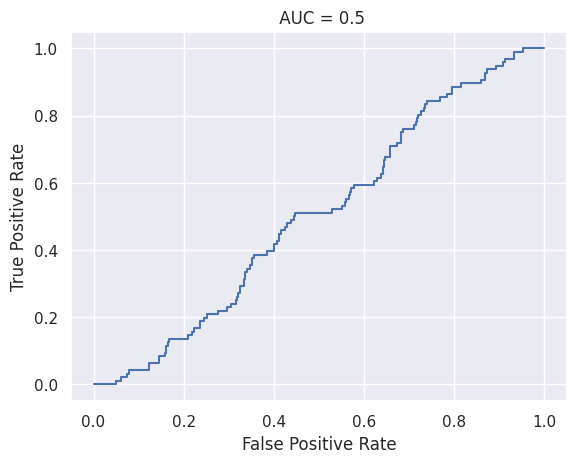

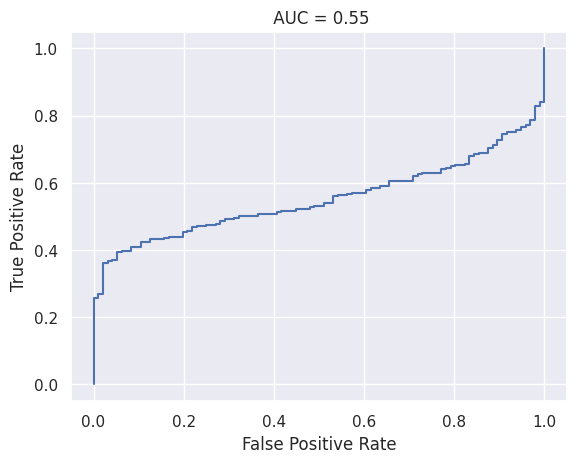

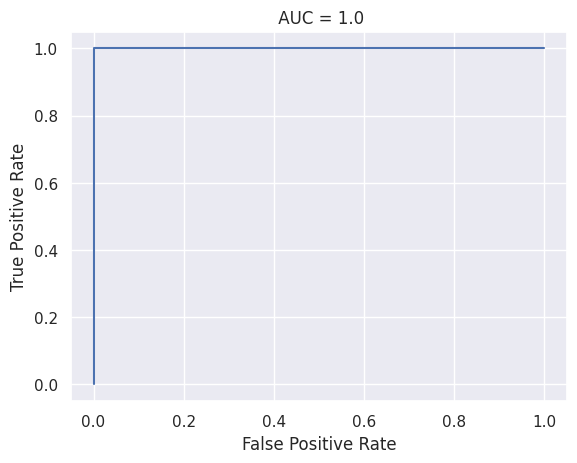

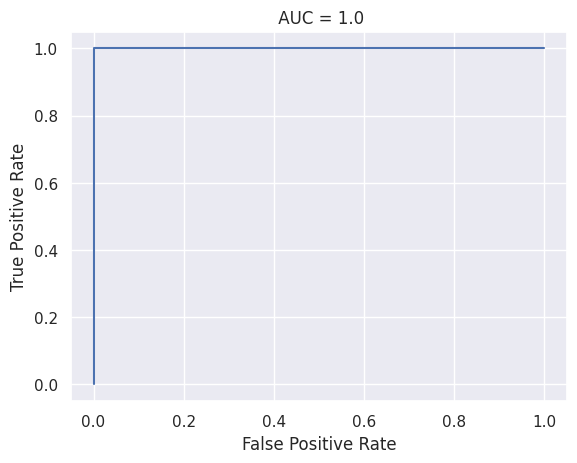

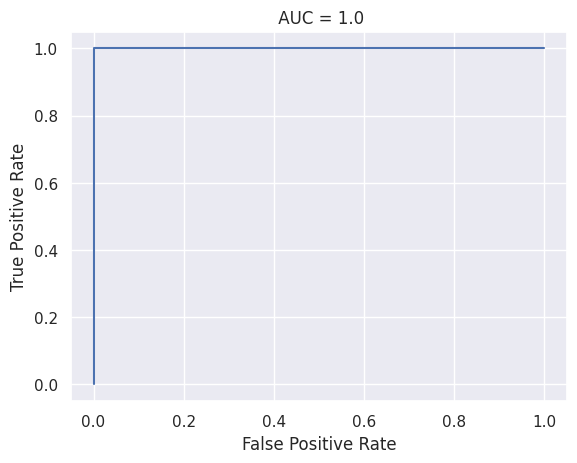

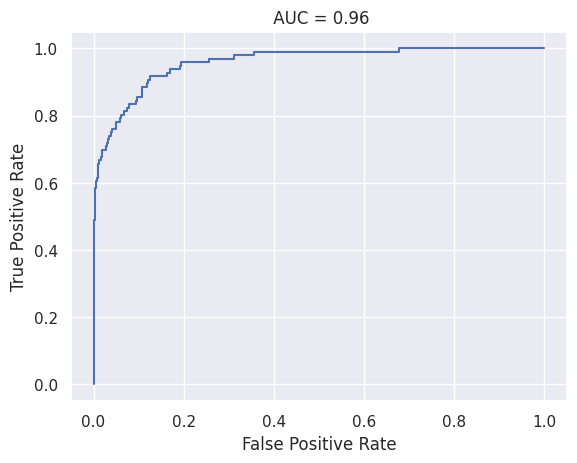

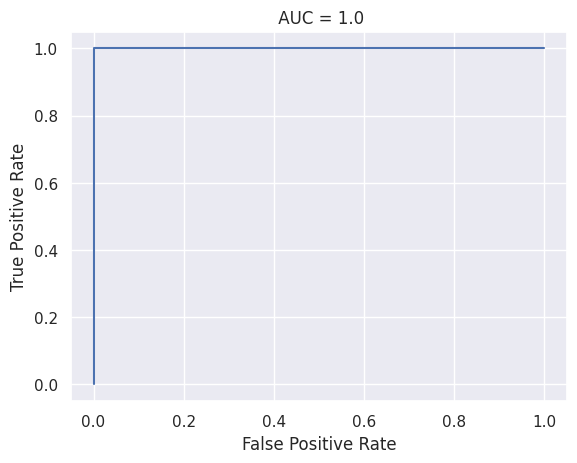

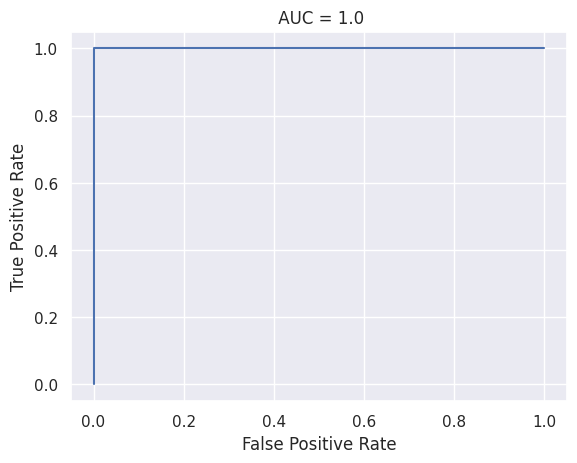

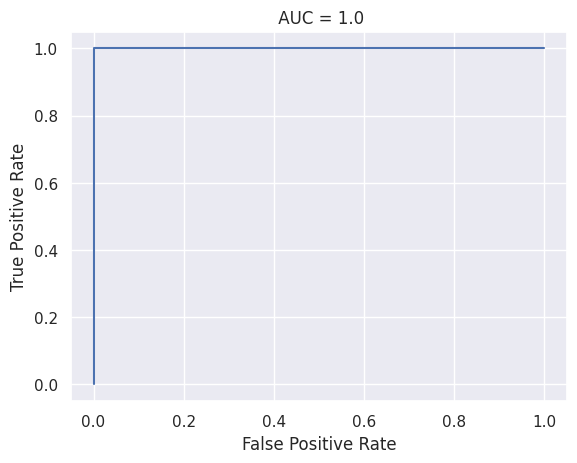

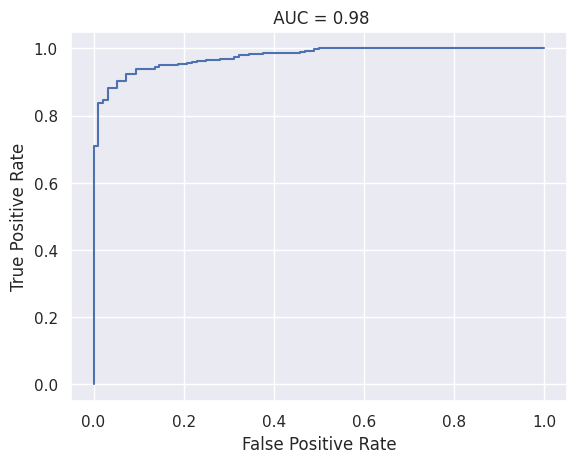

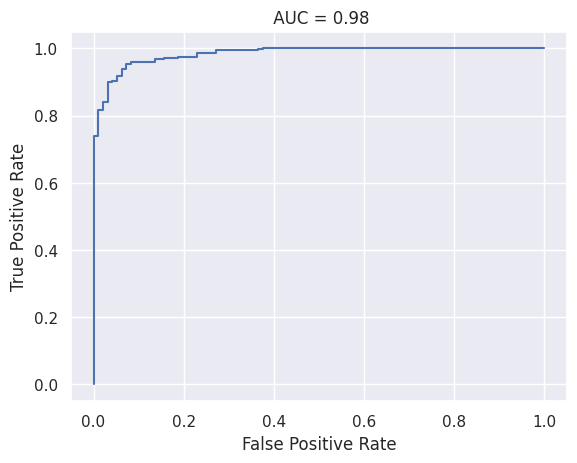

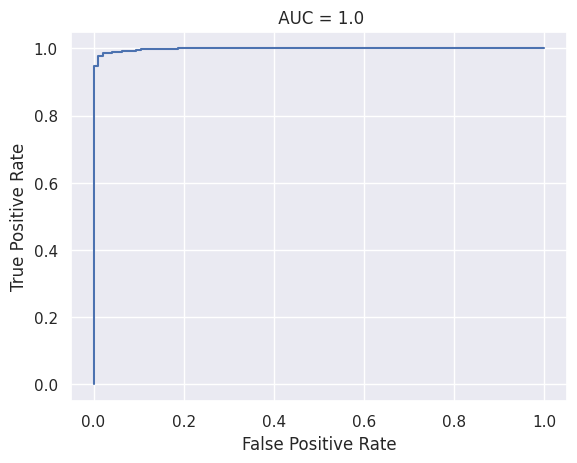

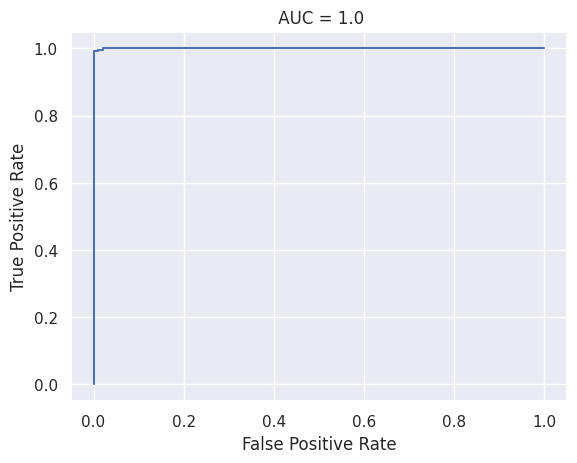

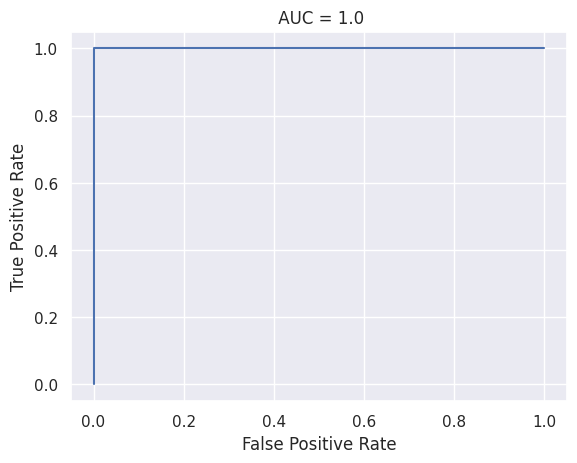

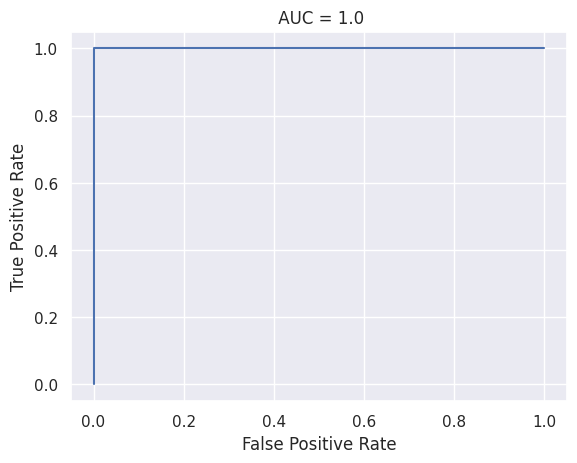

In [152]:
# processo da curva ROC
plt.figure(figsize=(12,5))
roc = []

for index in range(0,15):
  roc.append(t3_fazroc(norm_vigilia.T[:, index], norm_stage_4.T[:, index], nomecarac='', plotar=True))

<Figure size 1200x500 with 0 Axes>

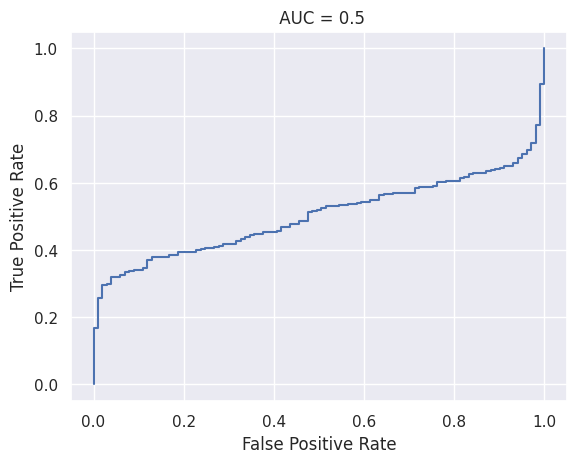

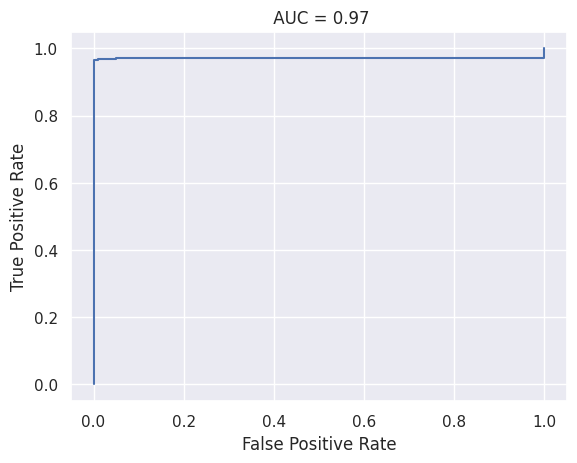

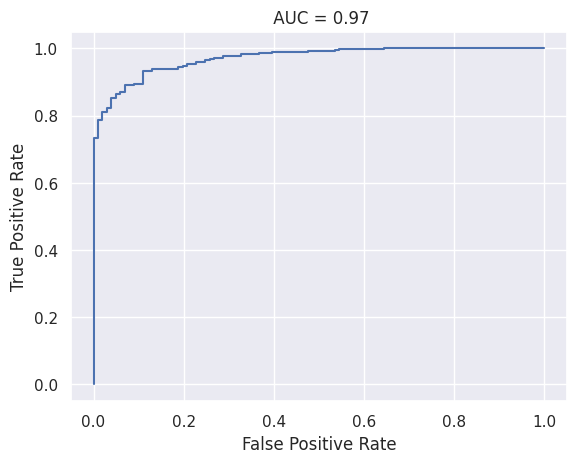

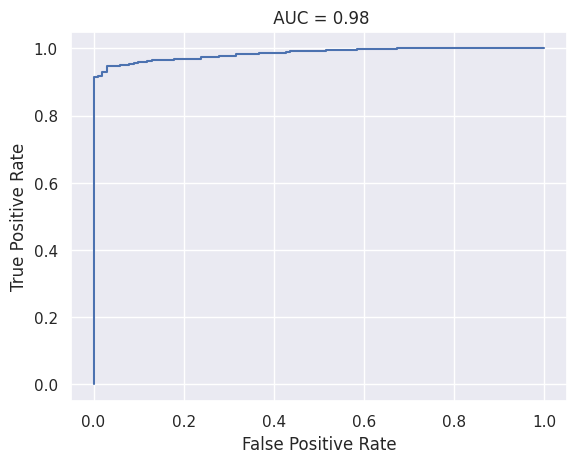

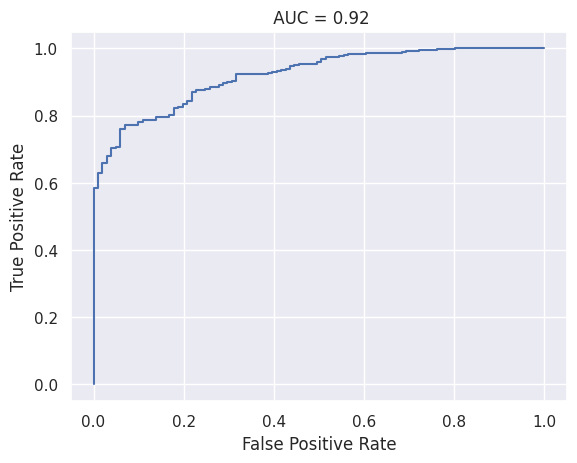

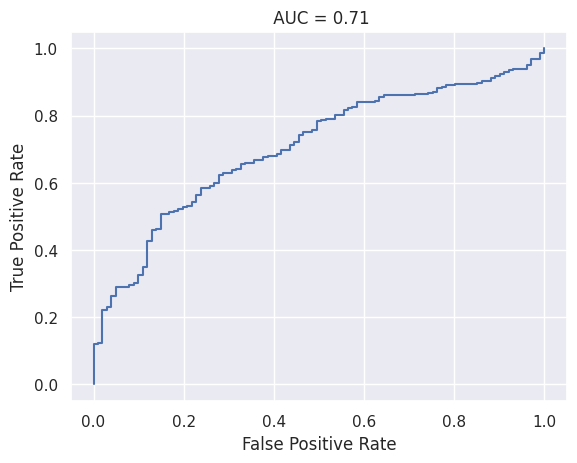

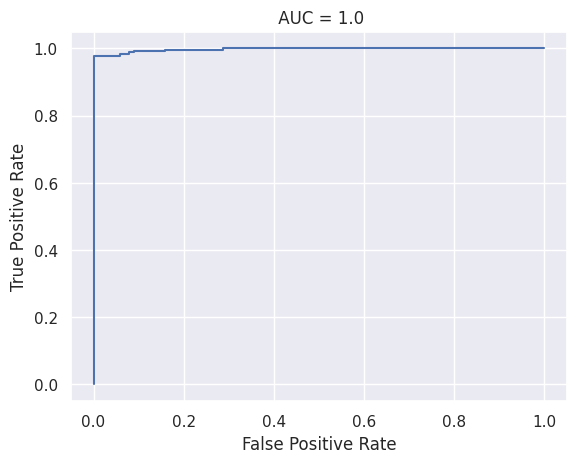

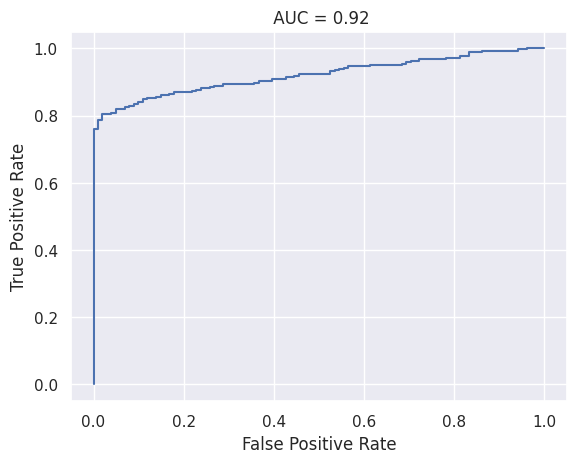

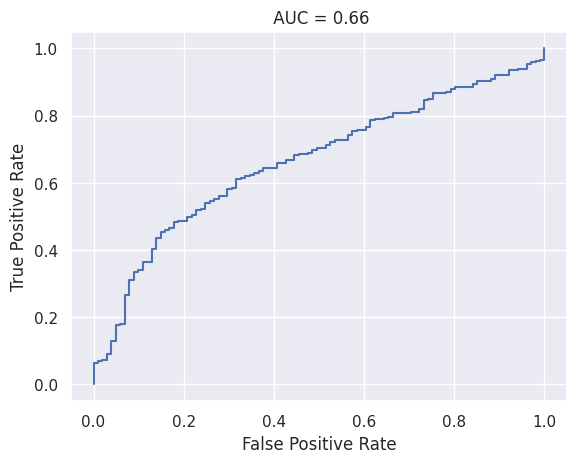

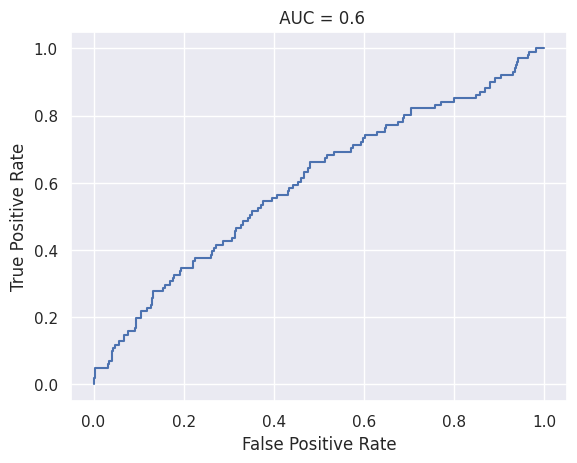

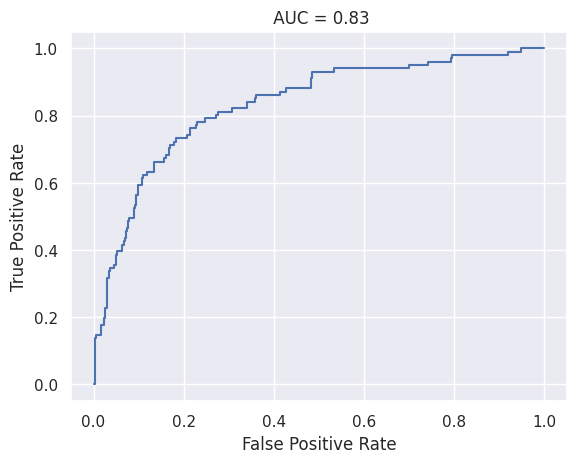

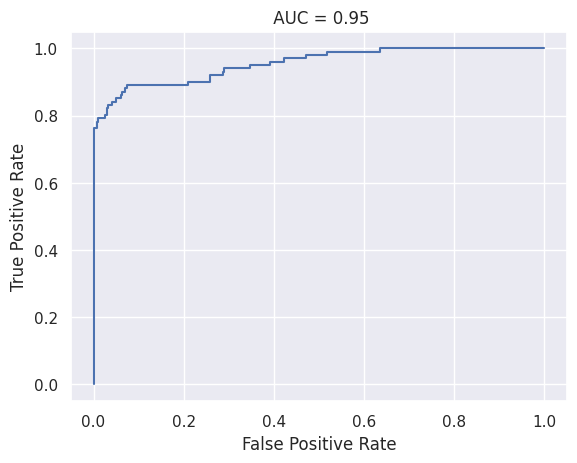

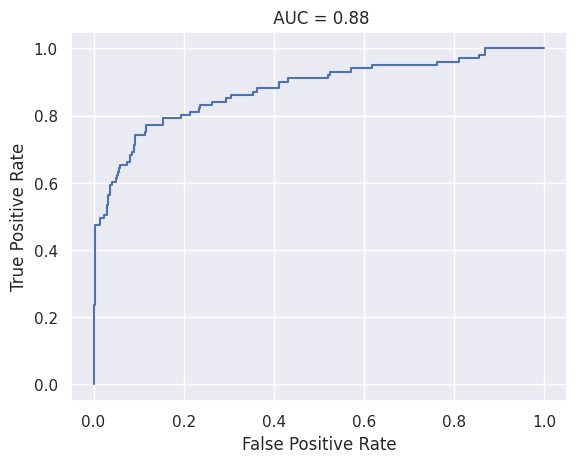

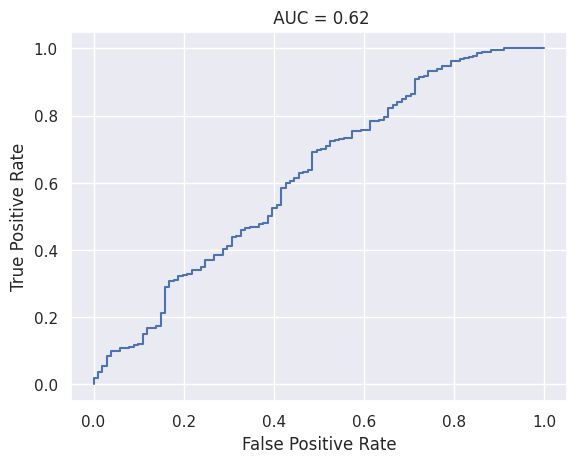

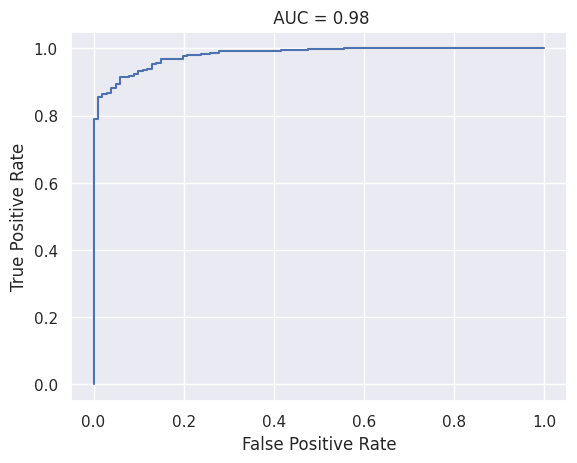

In [153]:
# processo da curva ROC
plt.figure(figsize=(12,5))
roc = []

for index in range(0,15):
  roc.append(t3_fazroc(norm_vigilia.T[:, index], norm_rem.T[:, index], nomecarac='', plotar=True))